<a href="https://colab.research.google.com/github/raspopovaa/Pet-Project-Data-Analyst/blob/main/%D0%A2%D0%B5%D0%BB%D0%B5%D0%BA%D0%BE%D0%BC_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B5%D1%8D%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D1%85_%D0%BE%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BE%D0%B2/%D0%A2%D0%B5%D0%BB%D0%B5%D0%BA%D0%BE%D0%BC_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B5%D1%8D%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D1%85_%D0%BE%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача**:**

Помогите «Нупозвони» найти самых неэффективных операторов. Признаки низкой эффективности:

- много пропущенных входящих вызовов,
- долгое ожидания ответа при входящих внешних вызовах,
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

1. **Проведите исследовательский анализ данных.**
2. **Определите неэффективных операторов.**
3. **Проверьте статистические гипотезы.**

## Откроем файл с данными и изучим общую информацию

In [1]:
#Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import datetime
import calendar
# %pip install ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%pip install seaborn==0.11.2
import seaborn as sns
from scipy import stats as st
#загружаем таблицы
try:
    df_c = pd.read_csv('/datasets/telecom_clients.csv')
    df_data = pd.read_csv('/datasets/telecom_dataset.csv')
except:
    print('Датасеты не загрузились, попробуйте открыть ноутбук в колабе')
    # Данный код загружает датасеты в колабе.
    ! gdown --id 1e3GHYqoyUl7CcogR_SQdKFs6Cirg9yiE
    ! gdown --id 14ovV6Xp3VBmm_0q5_qKoN8XUngtiDCr8
    df_c = pd.read_csv('/content/telecom_clients.csv')
    df_data = pd.read_csv('/content/telecom_dataset.csv')
# устанавливаем отображение количества столбцов экране 
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.2f}'.format # устанавливаем отображение числа знаков после точки.
import warnings
warnings.filterwarnings('ignore')


Датасеты не загрузились, попробуйте открыть ноутбук в колабе
Downloading...
From: https://drive.google.com/uc?id=1e3GHYqoyUl7CcogR_SQdKFs6Cirg9yiE
To: /content/telecom_clients.csv
100% 14.7k/14.7k [00:00<00:00, 18.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=14ovV6Xp3VBmm_0q5_qKoN8XUngtiDCr8
To: /content/telecom_dataset.csv
100% 3.42M/3.42M [00:00<00:00, 103MB/s]


Импортируем данные. Рассмотрим полученные таблице поближе.

In [2]:
df_c.info()
df_c.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
722,166797,B,2019-08-20
497,168526,B,2019-10-29


df_c - таблица с данными о клиентах «Нупозвони» — провайдера виртуальный телефонии. Его клиенты — колл-центры. К данным замечаний нет, но тип данных столбца date_start, нужно перевести в тип дата, тип данных tariff_plan нужно перевести в тип данных category.

In [3]:
df_data.info()
df_data.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
20598,167004,2019-10-29 00:00:00+03:00,out,False,900826.00,True,4,0,54
23545,167102,2019-09-06 00:00:00+03:00,in,False,NaN,True,1,0,50


df_data - таблица с данными о звонках операторов колл-центров. В столбце operator_id есть пропущенные значения, необходимо их заменить или удалить.Тип данных столбца date, нужно перевести в тип дата, тип данных столбцов direction, internal нужно перевести в тип данных category.

### Вывод

Мы имеем 2 таблицы с данными о звонках операторов колл-центров и о тарифах колл-центров. Столбцы в таблицах имеют разный тип данных. Таблицы удобные для анализа данных - в каждом столбце хранятся значения, каждая строка содержит одно наблюдение, к которому привязаны значения разных переменных. Название столбцов без пробелов, несколько слов разделяются нижним подчеркиванием, на одном языке и в одном регистре, отображают в краткой форме какого рода информация содержится в каждом столбце. В таблицах df_с, df_data, есть стоблцы тип данных которых нужно изменить на дату и тип данных category. В таблице df_data есть пропуски в стобце operator_id. Приступаем к подготовке данных для анализа.

## Подготовим данные

Для удобства дальнейших вычислений объеденим таблицы

In [4]:
df = df_data.merge(df_c, on = 'user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
 9   tariff_plan          53902 non-null  object 
 10  date_start           53902 non-null  object 
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 4.6+ MB


Изменим тип данных для оптимизации наших таблиц.

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['date_start'] = pd.to_datetime(df['date_start'])

In [6]:

df['tariff_plan'] = df['tariff_plan'].astype('category')
df['user_id'] = df['user_id'].astype('category')
df['operator_id'] = df['operator_id'].astype('category')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  category                             
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  category                             
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
 9   tariff

Проведем работу с пропущенными значениями в табице df_data

In [8]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
user_id,0.000000
date,0.000000
direction,0.000000
internal,0.220000
operator_id,15.160000
is_missed_call,0.000000
calls_count,0.000000
call_duration,0.000000
total_call_duration,0.000000
tariff_plan,0.000000


Пропуски в столбце internal составляют 0,22% от общего количества строк. В виду малого количества строк предлагаю удалить данные пропуски.

In [9]:
df = df.dropna(subset=['internal'])
df['internal'] = (df['internal']*1)


Пропуски в столбце operator_id составляю 15%, мы уже сможем удалить их без потери качества данных. В связи с тем, что мы будем анализировать данные операторов в целом предлагаю заменить пропуски на рандомное. Чтобы минимизировать влияние данной замены на данные предлагаю присвоить пропускам в operator_id номера которые будут зависить от user_id. Пропуск в operator_id будет равен user_id * 0,42.

In [10]:
df['operator_id'] = df.apply(lambda x: x['user_id']*0.42 if pd.isna(x['operator_id']) else x['operator_id'], axis=1)

Проведем работу с дублями.

In [11]:
df.duplicated().sum()

4893

В таблице 4893 полных дубликата, предлагаю удалить их. Так как они могут исказить общую статистику.

In [12]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              48892 non-null  category                             
 1   date                 48892 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            48892 non-null  object                               
 3   internal             48892 non-null  object                               
 4   operator_id          48892 non-null  float64                              
 5   is_missed_call       48892 non-null  bool                                 
 6   calls_count          48892 non-null  int64                                
 7   call_duration        48892 non-null  int64                                
 8   total_call_duration  48892 non-null  int64                                
 9   tariff

Мы избавились от пропусов и дубликатов, теберь нужно найти аномалии и ошибки в самих данных.

In [13]:
[df[col].describe() for col in df.columns if df[col].dtype in ['float','int64']]

[count    48892.00
 mean    788413.31
 std     303947.32
 min      69878.34
 25%     890416.00
 50%     906406.00
 75%     930020.00
 max     973286.00
 Name: operator_id, dtype: float64, count   48892.00
 mean       16.50
 std        63.67
 min         1.00
 25%         1.00
 50%         4.00
 75%        12.00
 max      4817.00
 Name: calls_count, dtype: float64, count    48892.00
 mean       868.09
 std       3779.55
 min          0.00
 25%          0.00
 50%         37.00
 75%        573.00
 max     144395.00
 Name: call_duration, dtype: float64, count    48892.00
 mean      1158.98
 std       4456.18
 min          0.00
 25%         46.00
 50%        210.00
 75%        902.00
 max     166155.00
 Name: total_call_duration, dtype: float64]

Столбец calls_count (кол-во звонков), видим аномально большое максимальное количество 4817 при медиане в 4 звонка. Думаю это ошибка в данных, нужно вычленить аномальные занчения и подумать, что с ними делать. Столбец call_duration (длительность звонка без учета времени ожидания) медиана 37, думаю данный показатель в секундах, максимальное значение 144395 секунд (2406 минут или 40 часов), это также явно ошибка в данных, нужно удалить аномальные знвчения. В столбце total_call_duration (длительность звонка с учетом времени ожидания) медиана 210 секунд максимальное значение также аномально. Видимо у некоторых операторов произошел сбой в сборе статиски звонков - посмотрим на эти звонки и посмотрим на этих операторов. 

Определим аномально большие значения. Создадим функцию. Так же при расчете анамально большого количества звонков не будем учитывать пропущенные звонки так как на них не тратится время оператора.

In [14]:
def mybox(df,title):
    q75, q25 = np.percentile(df, [75,25])
    iqr = q75 - q25
    min = q25 - (q25 +1.5*iqr)
    max = q75 + 1.5*iqr
    print('Граница нижнего уса: ', min)
    print('Граница верхнего уса: ', max)
    print(df.describe())
    fig = plt.figure(figsize =(10, 7)) 
    plt.ylim(0,max*1.2)
    plt.boxplot(df,sym='k+', notch=1,)
    plt.title(f'График "ящик с усами"для {title}')
    plt.show()
  

Посмотрим на диаграмму размаха количества звонков.

Граница нижнего уса:  -16.5
Граница верхнего уса:  29.5
count   27773.00
mean       15.53
std        49.39
min         1.00
25%         2.00
50%         4.00
75%        13.00
max      1480.00
Name: calls_count, dtype: float64


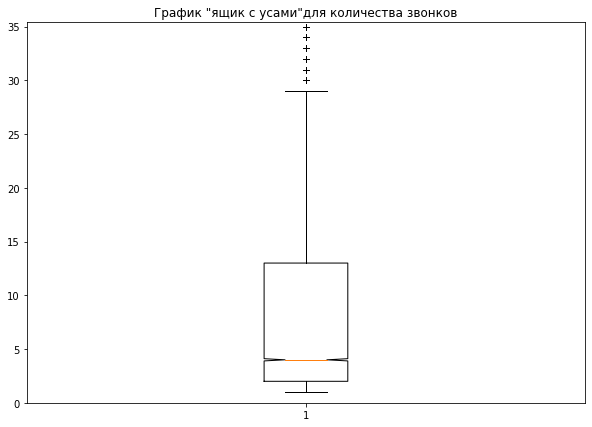

In [15]:
mybox(df.query('call_duration != 0').calls_count, 'количества звонков')

Макимальное значение 1480 звонков. Теоретичести 3 звонка в минуту. Думаю это возможно, Поэтому эти значения удалять не будем.

Посмотрим на диаграмму разброса длительности звонков.

Граница нижнего уса:  -1953.0
Граница верхнего уса:  3361.0
count    27773.00
mean      1528.20
std       4913.16
min          1.00
25%        106.00
50%        436.00
75%       1408.00
max     144395.00
Name: call_duration, dtype: float64


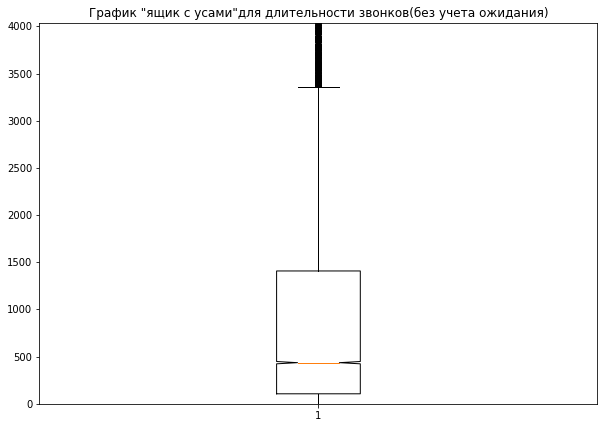

In [16]:
mybox(df.query('call_duration !=0').call_duration, 'длительности звонков(без учета ожидания)')

Максимальное значение длительности звонков 144395 это 40 часов, думаю это ошибочные данные их нужно удалить. Так как таких значений всего 120 их удаление не изменит общие показатели. 

In [17]:
df = df.query('call_duration <= 28800')

Посмотрим на аномальные значения количества звонков, напомню, что верхняя граница "ящика с усами" 35 звонков, в принципе это 4 звонка в час (прямо скажем, производительность труда у операторов не на высоте). Конечно могут быть разные ситуации и нужно вычислять параметры эффективности исходя из медианных значений. Но думаю 4 звонка в час для колл-центра это не нормально. Мое мнение, что вычислять такие показатели нужно после фотографии рабочего времени оператора. 
Посмотрим на аномальные значения длительности звонков, напомню, что верхняя граница "ящика с усами" 3368 секунды, в принципе это 1 час из 8 часового раб дня, прямо скажем, производительность труда у операторов не на высоте. Попробуем вычислить максимально возможную длительность. Получаеться 30 звонков в час, умножим на 8 часой рабочий день, получаем 240 звонков в день это возможно. 

### Вывод

Мы подготовили наши данные для анализа. Объеденили таблицы, изменили типы данных, частично удалили ичастично заполнили пропуски в значениях. Удалили дубликаты. Удалили экстремальные значения количества звонков. Значения длительности звонка решили оставить так как теоретически они возможны. Приступим к анализу наших данных

## Проанализируем данные

### Нам нужно определить какому количеству клиентов будет интересна эта услуга. Думаю такая услуга будет интересна любому клиенту. Они должны в реальном времени получать такую информацию, что позволит им вовремя реагировать на эффективность операторов. Но все же посмотрим на количество операторов с долей пропущенных входящих звонков более 25% от общего количества входящих звонков.

In [18]:
df2 = df.query('direction == "in"').groupby(['user_id', 'direction'])['is_missed_call'].mean().reset_index().query('is_missed_call > 0.25')


In [19]:
print(f' У {round(df2.user_id.nunique() / df.user_id.nunique()*100,2)} % процентов колл-центров доля пропущенных звонков более 25%.')

 У 88.93 % процентов колл-центров доля пропущенных звонков более 25%.


88 % наших клиентов, потенциально будет интересно определение не эффективных операторов.

### Посмотрим как ведут себя показатели в течение времени.


In [20]:
df['day'] = pd.DatetimeIndex(df['date']).day

In [21]:
df['weekday'] = df['date'].dt.day_name()
df['week'] = df['date'].dt.week

Посмотрим на распределение количества звонков(пропущенных и не пропущенных) по дням месяца, дням недели и по неделям.

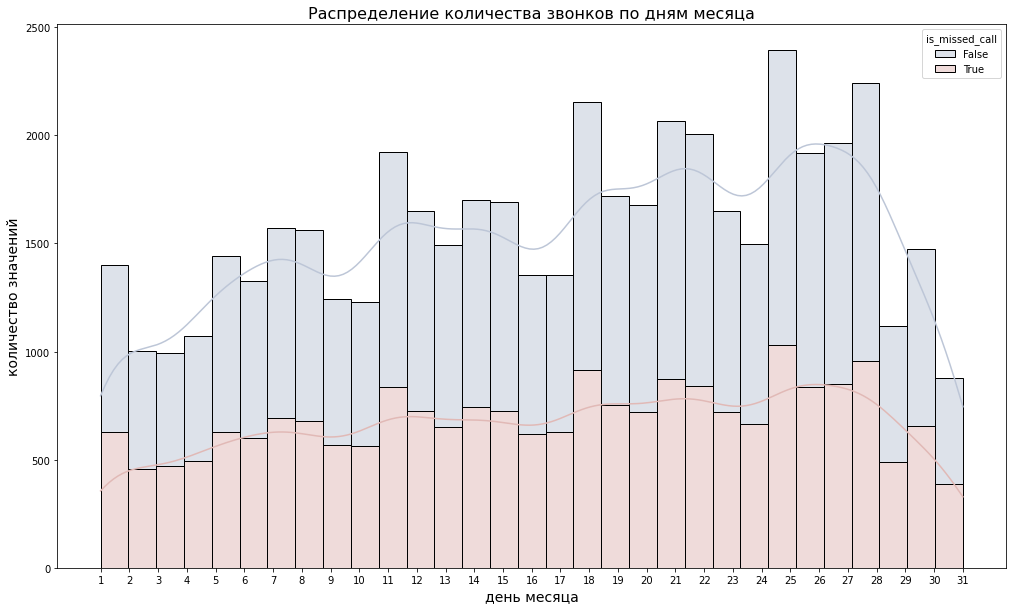

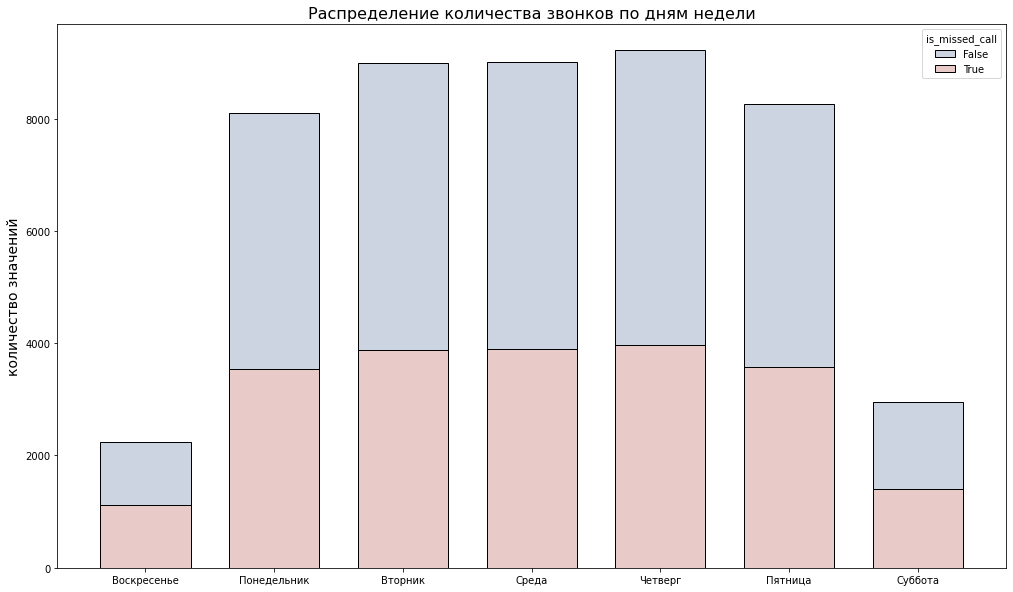

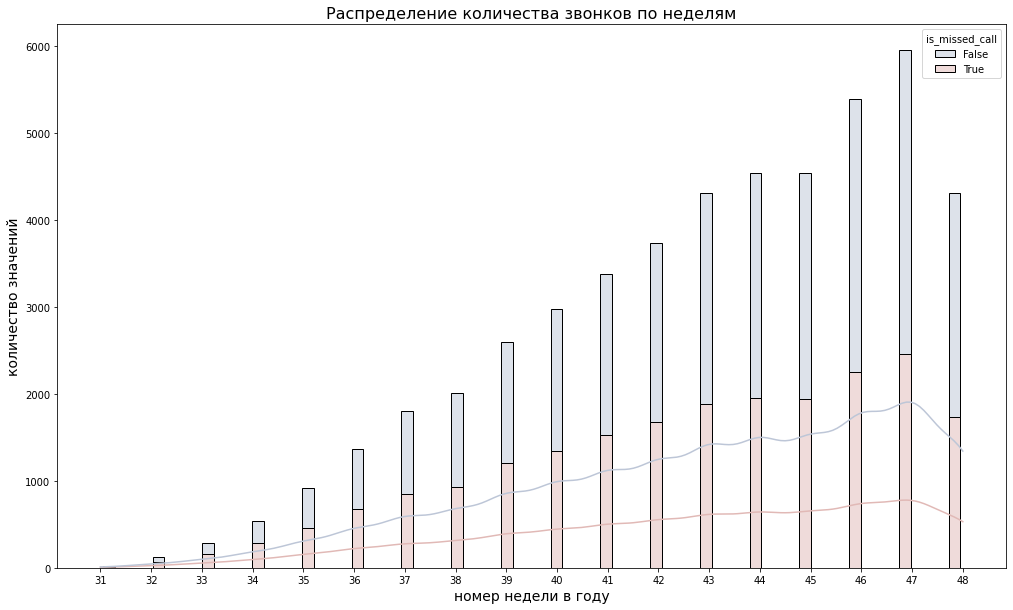

In [22]:
plt.figure(figsize=(17, 10))
ax = sns.histplot(df, x='day', hue='is_missed_call', bins=31, kde=True, palette="vlag",  multiple="stack",)
plt.xticks(list(range(1, 32)))
ax.axes.set_title("Распределение количества звонков по дням месяца", fontsize=16)
ax.set_xlabel("день месяца", fontsize=14)
ax.set_ylabel("количество значений", fontsize=14)

plt.figure(figsize=(17, 10))
ax = sns.histplot(df, x='weekday', hue='is_missed_call', shrink=0.7, palette="vlag",  multiple="stack")
plt.xticks(['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday','Saturday'],
           ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница','Суббота'])
ax.axes.set_title("Распределение количества звонков по дням недели", fontsize=16)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("количество значений", fontsize=14)

plt.figure(figsize=(17, 10))
ax = sns.histplot(df, x='week', hue='is_missed_call', shrink=0.7, palette="vlag", kde=True,  multiple="stack")
plt.xticks(list(range(31, 49)))
ax.axes.set_title("Распределение количества звонков по неделям", fontsize=16)
ax.set_xlabel("номер недели в году", fontsize=14)
ax.set_ylabel("количество значений", fontsize=14)
plt.show()

Из рисунков мы наблюдаем цикличное уменьшение количества звонков в выходные дни. думаю это связанно с уменьшением количества работающих операторов в выходные. Соотноешение пропущенных и не пропущенных значений примерно одинаковое.

### Вычислим новые показатели из имеющихся для дальнейшего анализа.

In [23]:
df['call_duration_min'] = round((df.call_duration / 60), 3) #перевели секунды в минуты
df['total_call_duration_min'] = round((df.total_call_duration / 60), 3) #перевели секунды в минуты
df['wait'] = round((df['total_call_duration'] - df['call_duration']), 3) # вычислили общее ожидание
df['avr_wait'] = round((df['total_call_duration'] - df['call_duration'])/df['calls_count'], 3) # вычислили средее ожидание на 1 звонок
df['aver_call_duration'] = round((df['call_duration']/df['calls_count']), 3) # вычислили среднюю продолжительность одного звонка
print(df['avr_wait'].describe())
print('-----------------------')
print(df['aver_call_duration'].describe())

count   48768.00
mean       16.83
std        13.89
min         0.00
25%         8.00
50%        14.50
75%        22.29
max       465.00
Name: avr_wait, dtype: float64
-----------------------
count   48768.00
mean       66.43
std       125.31
min         0.00
25%         0.00
50%        23.25
75%        89.53
max      3550.00
Name: aver_call_duration, dtype: float64


Посмотрим на корреляцию новых показателей с имеющимися данными.

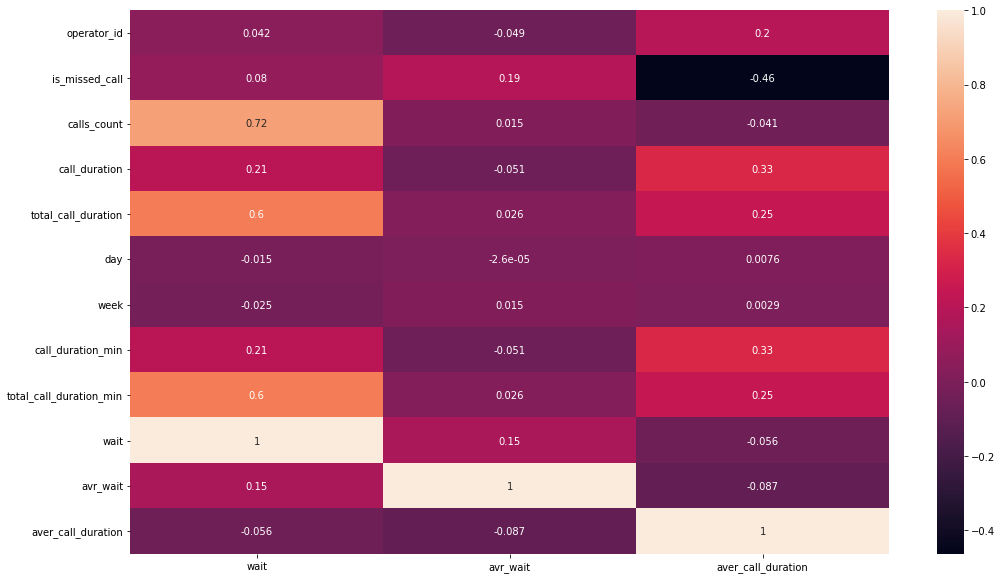

In [24]:
plt.figure(figsize=(17, 10))
Var_Corr = df.corr()
sns.heatmap(Var_Corr[['wait','avr_wait', 'aver_call_duration']],annot=True)
plt.show()

Наблюдаем несколько достаточно высоких и логичных взаимосвязей. Чем больше пропущенных звонко тем больше среднее ожидание и тем меньше средняя продолжительность звонка.  

## Разработаем алгоритм и составим его описание. 
Предлагаю присвоить каждому оператору скоринг 0, 0.25, 0.5, 0.75, и 1 исходя из эффективности оператора. Применение скоринга обусловлено его гибкостью, уневерсальностью и возможностью к масштабированию. Клиент сам может решить какой уровень скоринга для него приемлем и отследить его в течение всего времени. Так же при необходимости можно не учитывать один из признаков или добавить новый.

Наши признаки эффективности:
- много пропущенных входящих вызовов. 
- долгое ожидания ответа при входящих внешних вызовах. 
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков. 


## Присвоим скоринг каждому оператору

### 	Пропущенные звонки.

Посмотрим диаграмму разброса количества пропущенных входящих звонков  у операторов.

Граница нижнего уса:  -7.5
Граница верхнего уса:  13.5
count   7833.00
mean      13.30
std       79.84
min        1.00
25%        1.00
50%        2.00
75%        6.00
max     2168.00
Name: calls_count, dtype: float64


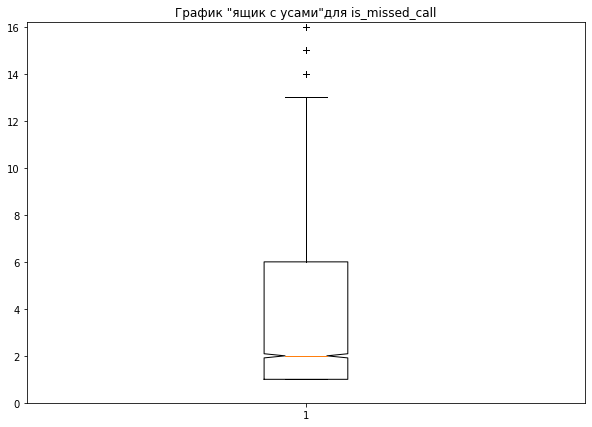

In [25]:
mybox(df.query('direction == "in" and is_missed_call == True')['calls_count'], 'is_missed_call')

Оценим наших операторов исходя из их показателей. Так как это операторы колл-центра у них не должно быть пропущенных звонков, ведь это их основная работа. Значит за 0 пропущенных звонков присвоим 0 баллов, от 1 до 2 -  0,5 балла, от 2 до 6 - 0,75 балла, болше 6 - 1 балл. Создадим функцию для оценки операторов.

In [26]:
def miss_score(row):
  if row['direction'] == "in" and row['is_missed_call'] == True and 0 <= row['calls_count'] < 1:
    return 0
  elif row['direction'] == "in" and row['is_missed_call'] == True and 1 <= row['calls_count'] <= 2:
    return 0.5
  elif row['direction'] == "in" and row['is_missed_call'] == True and 2 < row['calls_count'] <= 6:
    return 0.75
  elif row['direction'] == "in" and row['is_missed_call'] == True and 6 < row['calls_count']:
    return 1
  else:
    return 0


In [27]:
df['miss_score'] = df.apply(miss_score, axis = 1)

In [28]:
df.sample(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,day,weekday,week,call_duration_min,total_call_duration_min,wait,avr_wait,aver_call_duration,miss_score
31929,167445,2019-11-18 00:00:00+03:00,in,0,920852.00,True,1,0,21,B,2019-09-17,18,Monday,47,0.00,0.35,21,21.00,0.00,0.50
4283,166503,2019-11-12 00:00:00+03:00,out,0,906680.00,True,4,0,80,B,2019-08-06,12,Tuesday,46,0.00,1.33,80,20.00,0.00,0.00
13223,166782,2019-10-26 00:00:00+03:00,in,0,893804.00,False,16,864,931,C,2019-08-19,26,Saturday,43,14.40,15.52,67,4.19,54.00,0.00


В столбце miss_score мы отценили наших операторов. Так же поступим и по другим целевым параметрам.

### Долгое ожидания ответа при входящих внешних вызовах. 

Для ценки операторов в зависимости от ожидания клиентом, будем использовать вычесленный нами показатель среднего ожидания на один входящий звонок мы записали его как 'avr_wait'. Посмотрим разбросс значений.

Граница нижнего уса:  -24.768
Граница верхнего уса:  48.28
count   19894.00
mean       17.32
std        17.02
min         0.00
25%         7.00
50%        13.00
75%        23.51
max       465.00
Name: avr_wait, dtype: float64


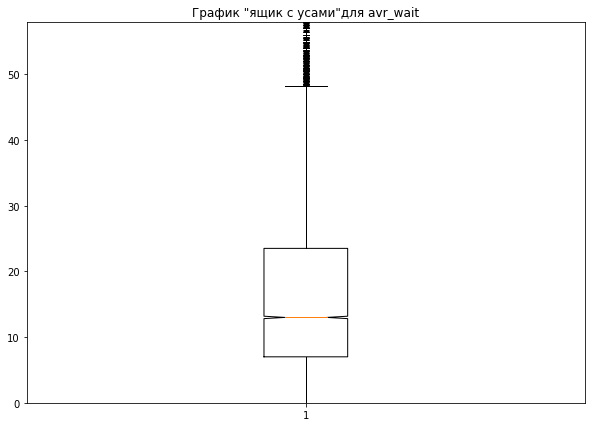

In [29]:
mybox(df.query('direction == "in"')['avr_wait'], 'avr_wait')

Создадим функцию.

In [30]:
def wait_score(row):
  if row['direction'] == "in" and 0 <= row['avr_wait'] < 7:
    return 0
  elif row['direction'] == "in" and 7 <= row['avr_wait'] < 13:
    return 0.25
  elif row['direction'] == "in" and 13 <= row['avr_wait'] < 23:
    return 0.5
  elif row['direction'] == "in" and 23 <= row['avr_wait']:
    return 1
  else:
    return 0

In [31]:
df['wait_score'] = df.apply(wait_score, axis = 1)

In [32]:
df.sample(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,day,weekday,week,call_duration_min,total_call_duration_min,wait,avr_wait,aver_call_duration,miss_score,wait_score
52228,168361,2019-11-02 00:00:00+03:00,out,0,945286.00,False,126,6421,9012,A,2019-10-23,2,Saturday,44,107.02,150.20,2591,20.56,50.96,0.00,0.00
9587,166658,2019-11-10 00:00:00+03:00,out,0,890404.00,True,4,0,92,B,2019-08-13,10,Sunday,45,0.00,1.53,92,23.00,0.00,0.00,0.00
35494,167532,2019-10-25 00:00:00+03:00,in,0,70363.44,True,9,0,213,C,2019-09-19,25,Friday,43,0.00,3.55,213,23.67,0.00,1.00,1.00


В столбце wait_score мы оценили операторов в зависимости от времени ожидания клиентом.

### Мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

Посмотрим на разбросс показателей количество исходящих звонков. Причем будем учитывать только звонки дозвонившиеся до клиента. Чтобы более эффективно отценить оператора и показать его реальную эффективность.

Граница нижнего уса:  -21.0
Граница верхнего уса:  36.0
count   13564.00
mean       20.02
std        76.96
min         1.00
25%         1.00
50%         4.00
75%        15.00
max      4817.00
Name: calls_count, dtype: float64


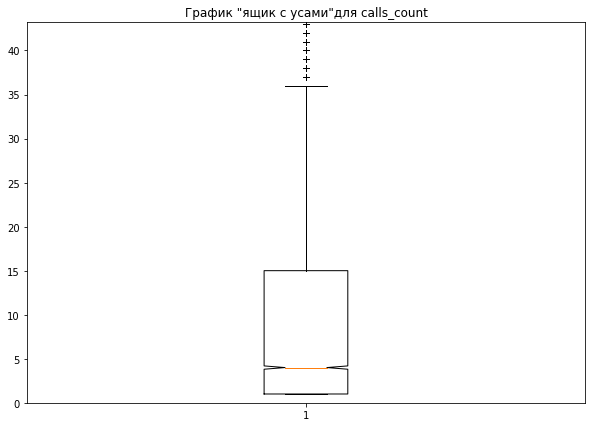

In [33]:
mybox(df.query('direction == "out" and is_missed_call == True')['calls_count'], 'calls_count')

Создадим функцию. Так же поясню, что исходящие пропущенные звонки будут отцениваться  0 , так как оператор не виноват что клиенты не взяли трубку.

In [34]:
def calls_count_score(row):
  if row['direction'] == "out" and row['is_missed_call'] == False and 0 <= row['calls_count'] <= 3:
    return 1
  elif row['direction'] == "out" and row['is_missed_call'] == False and 3 < row['calls_count'] <= 9:
    return 0.5
  elif row['direction'] == "out" and row['is_missed_call'] == False and 9 < row['calls_count'] <= 24:
    return 0.25
  elif row['direction'] == "out" and row['is_missed_call'] == False and 24 < row['calls_count']:
    return 0
  else:
    return 0

In [35]:
df['calls_count_score'] = df.apply(calls_count_score, axis = 1)

Мы отценили операторов по трем параметрам. теперь можем вывести общий бал.

In [36]:
df['total_score'] = df['miss_score'] + df['wait_score'] + df['calls_count_score']

In [37]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,day,weekday,week,call_duration_min,total_call_duration_min,wait,avr_wait,aver_call_duration,miss_score,wait_score,calls_count_score,total_score
0,166377,2019-08-04 00:00:00+03:00,in,0,69878.34,True,2,0,4,B,2019-08-01,4,Sunday,31,0.00,0.07,4,2.00,0.00,0.50,0.00,0.00,0.50
1,166377,2019-08-05 00:00:00+03:00,out,1,880022.00,True,3,0,5,B,2019-08-01,5,Monday,32,0.00,0.08,5,1.67,0.00,0.00,0.00,0.00,0.00
2,166377,2019-08-05 00:00:00+03:00,out,1,880020.00,True,1,0,1,B,2019-08-01,5,Monday,32,0.00,0.02,1,1.00,0.00,0.00,0.00,0.00,0.00
3,166377,2019-08-05 00:00:00+03:00,out,1,880020.00,False,1,10,18,B,2019-08-01,5,Monday,32,0.17,0.30,8,8.00,10.00,0.00,0.00,1.00,1.00
4,166377,2019-08-05 00:00:00+03:00,out,0,880022.00,True,3,0,25,B,2019-08-01,5,Monday,32,0.00,0.42,25,8.33,0.00,0.00,0.00,0.00,0.00


Посмотрим на распределение оценок для входящих и исходящих вызовов.

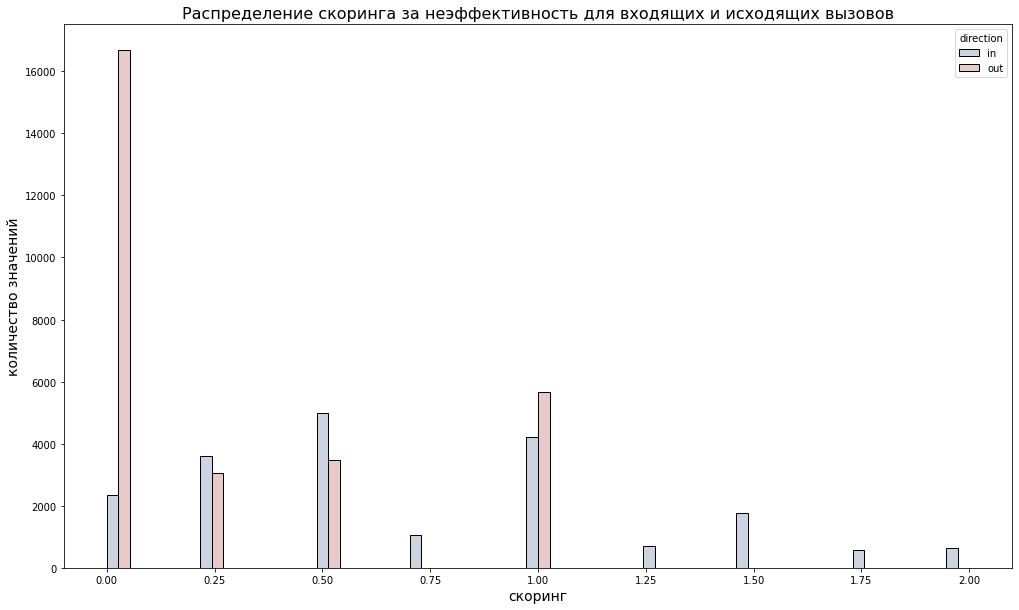

In [38]:
plt.figure(figsize=(17, 10))
ax = sns.histplot(df, x='total_score', hue='direction', kde=False, palette="vlag", multiple='dodge')
ax.axes.set_title("Распределение скоринга за неэффективность для входящих и исходящих вызовов", fontsize=16)
ax.set_xlabel("скоринг", fontsize=14)
ax.set_ylabel("количество значений", fontsize=14)
#ax.set_yscale('log')
plt.show()

Тут стоит заметь. что сравнивать скоринг по входящим и исходящим не корректно и стоит рассматривать отдельно. Так как для входящих звонков для оценки мы ипользовали сумму двух покателей, а для оценки исходящих только одного покателя.  Это значит, что оценивать наших операторов нужно отдельно по исходящим и входящим звонкам. 

Посмотрим на корреляцию значений скоринга по ожиданию на все остальные значения

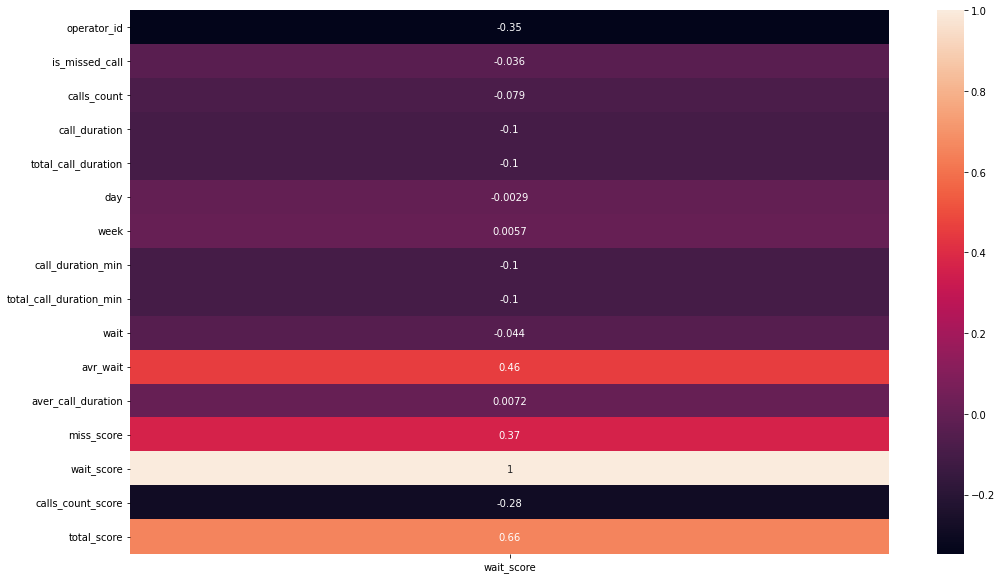

In [39]:
plt.figure(figsize=(17, 10))
Var_Corr = df.corr()
sns.heatmap(Var_Corr[['wait_score']],annot=True)
plt.show()

Значимой корреляции не наблюдаем.  В данной таблице нет значений тарифного плана. Посмотрим на них отдельно.

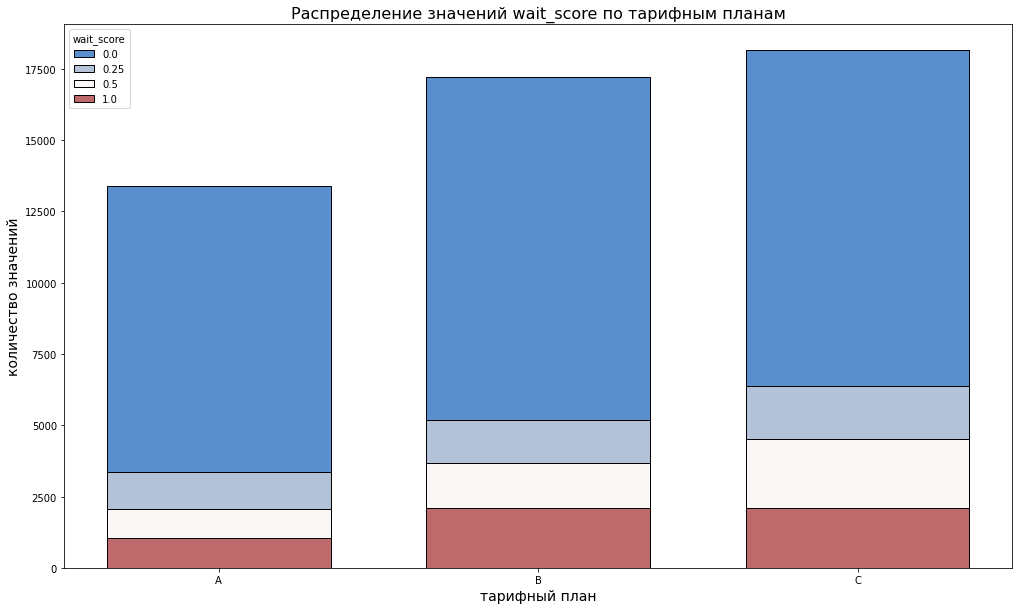

In [40]:

plt.figure(figsize=(17, 10))
ax = sns.histplot(df, x='tariff_plan', hue='wait_score', shrink=0.7, palette="vlag",  multiple="stack")

ax.axes.set_title("Распределение значений wait_score по тарифным планам", fontsize=16)
ax.set_xlabel("тарифный план", fontsize=14)
ax.set_ylabel("количество значений", fontsize=14)
plt.show()

Нас интересует соотношение размера скоринга в каждом тарифе. Соотношение в тарифах А и В приблизительно одинаковое. В тарифе С видим увеличенную долю скоринга 0,5. Исходя из этого можно предположить что значения ожидания в тарифном плане С отличаеться от А и В. 

### Вывод

Мы проанализировали наши данные. Показали, что 88 % колл-центров было бы интересно знать эффективность своих операторов. Вычислили новые показатели ожидания и продолжительности звонка. Увидели уменьшение количества звонков в выходные дни. Разработали и применили алгоритм опредления эффективности операторов. Благодаря алгоритму клиент сам может решить какой уровень скоринга для него приемлем и отследить его в течение всего времени. Так же при необходимости можно не учитывать один из признаков или добавить новый. Так же мы нашли предположительную взаимосвязь тарифного плана с временем ожидания. предлагаю проверить эту гипотезу.

## <div class="alert alert-info"> Разделим колл-центры на ктегории - входящие/исходящие/мультифункциональные. Посмотрим есть ли в них отличия по эффективности или другие инсайты</div>

Для категоризации клиентов сгруппируем данные по направлению звонков. Так же при группировке будем учитывать только те звонки на которые ответили.

In [41]:
df_group_dir = df.query('call_duration != 0').pivot_table(index = ['user_id'], columns =['direction'], values = ['calls_count'], aggfunc = (sum)).fillna(0).reset_index()
df_group_dir.columns = ['user_id', 'in', 'out']


In [42]:
df_group_dir


,user_id,in,out
0,166377,102,3167
1,166391,6,0
2,166392,102,0
3,166399,13,0
4,166405,2177,6461
...,...,...,...
302,168583,22,0
303,168598,21,0
304,168601,79,340
305,168603,0,10


Создадим функцию для присвоения определенной категории колл-центру. Предлагаю распределять клиентов следующим образом. Если есть хоть один входящий и исходящий категория <b>in_out</b>, если нет входящих, то <b>out</b>, если нет исходящих то <b>in</b>. 

In [43]:
def group_dir(row):
    if (row['in'] !=0) & (row['out'] !=0):
        return 'in_out'
    elif (row['in'] != 0) & (row['out'] == 0):
         return 'in'
    elif (row['in'] == 0) & (row['out'] != 0):
        return 'out'
    else:
        return 'проверить'

Посмотрим на распределение категорий

In [44]:
df_group_dir['direction_group'] = df_group_dir.apply(group_dir, axis =1)
df_group_dir['direction_group'].value_counts()

in_out       197
in            76
проверить     20
out           14
Name: direction_group, dtype: int64

Присоединем полученные данные к основной таблице.

In [45]:
t = df_group_dir[['user_id', 'direction_group']]
t

,user_id,direction_group
0,166377,in_out
1,166391,in
2,166392,in
3,166399,in
4,166405,in_out
...,...,...
302,168583,in
303,168598,in
304,168601,in_out
305,168603,out


In [46]:
df = df.merge(t, on = 'user_id')

Сгруппируем данные для определения зависимости между новыми категориями и скорингом. Так же нам надо помнить и учеть особенность скоринг при определении не эффективности для входящих звонков использовали 2 показателя а для исходящих 1 показатель. Поэтому не корректно будет сравнивать категории по Total_score. Предлагаю сравнить вычисленные нами miss_score, wait_score, calls_count_score по доле максимально не эффектиных операторов, т.е получивших 1 балл.

In [47]:
t1 = df[df['miss_score'] == 1]['direction_group'].value_counts()
t11 = df['direction_group'].value_counts()
t_1 = t1/t11


In [48]:
t2 = df[df['wait_score'] == 1]['direction_group'].value_counts()
t11 = df['direction_group'].value_counts()
t_2 = t2/t11


In [49]:
t3 = df[df['calls_count_score'] == 1]['direction_group'].value_counts()
t11 = df['direction_group'].value_counts()
t_3 = t3/t11


                   in_out   in  out  проверить
miss_score           0.04 0.05 0.05       0.09
wait_score           0.10 0.29 0.02       0.00
calls_count_score    0.13 0.00 0.05       0.00


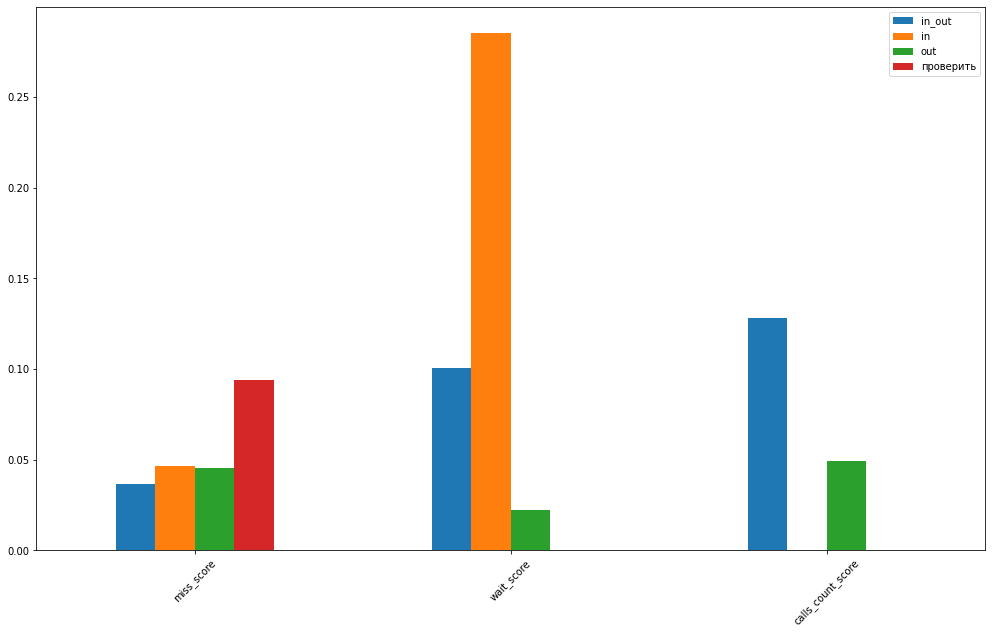

In [50]:
t = [t_1[0:], t_2[0:], t_3[0:]]
x = pd.DataFrame(t).fillna(0)
x.index = ['miss_score','wait_score','calls_count_score']
print(x)

x.plot(kind='bar',figsize=(17, 10))
plt.xticks(rotation = 45)
plt.show()

Из рисунка видим, что значительная часть, 29% , всех самых не эффективных по ожиданию  операторов из колл-центров с категорией in. Это те колл-центры которым пригодится наша услуга в первую очередь. Опредделим кому конкретно можно предложить эту услугу.

## <div class="alert alert-info"> Определим к каким клиентам нам стоит идти в-первую очередь, чтобы презентовать новую фичу для клиентов</div>

Очевидный ответ на вопрос: "к кому нам стоит идти в первую очередь, чтобы презетовать услугу" - это к клиентам имеющим самую большую долю не эффективных операторов за все время наблюдений. Будем рассматривать только колл-центры с категорией in, так у них больше всего проблемных операторов. 

In [51]:
df_first = df.query('direction_group == "in"').pivot_table(index=['user_id','operator_id'], values='total_score', aggfunc=['count', 'mean']).reset_index()
df_first.columns = ['user_id', 'operator_id', 'total_score_count','total_score_mean']

Присвоим всем оператором имеющим средний балл юольше или равно 1 метку 1, если меньше то 0.

In [52]:
def bad_operator(row):
    if row['total_score_mean'] >= 1:
        return 1
    else:
        return 0

In [53]:
df_first['flag'] = df_first.apply(bad_operator, axis=1)
df_first


,user_id,operator_id,total_score_count,total_score_mean,flag
0,166377,69884.22,0,NaN,0
1,166377,69884.64,0,NaN,0
2,166377,69887.58,0,NaN,0
3,166377,69899.76,0,NaN,0
4,166377,69922.02,0,NaN,0
...,...,...,...,...,...
61702,168606,968520.00,0,NaN,0
61703,168606,971100.00,0,NaN,0
61704,168606,971102.00,0,NaN,0
61705,168606,971354.00,0,NaN,0


Метки 0 и 1, помогут нам быстро и просто, вычислить долю не эффективных операторов, вычислив среднее.

In [54]:
df_first.groupby('user_id')['flag'].agg(['count', 'mean']).sort_values(by='mean',ascending=False).query('mean >= 0.5')

,count,mean
user_id,,


Мы выгрузили список из 24 клиента где 50% операторов не эффективных. Да мы видим что, есть колл-центры с малым количеством операторов. Но я думаю количество операторов не имеет значение. 

## Проверка гипотезы

### Подтвердим гипотезу, что среднее время ожидания у клиентов с тарифным планом А, В и С отличается.


Создадим выбоки

In [55]:
sample_01 = df.query('tariff_plan == "A"')
sample_02 = df.query('tariff_plan == "B"')
sample_1 = sample_01.loc[:,['avr_wait']]
sample_2 = sample_02.loc[:,['avr_wait']]

Применим Т-тест для подтверждения гипотезы о равенстве средних двух генеральных совокупностей. Проверим гипотезы -  среднее время ожидания у тарифа А и В различается. Нулевая гипотеза будет звучать как sample_01 (среднее вермя ожидания по тарифу А) = sample_02 (среднее вермя ожидания по тарифу В), альтернативная гипотеза sample_01 != sample_02. Зададим p-value = 0.05.

In [56]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: [0.37690886]
Не получилось отвергнуть нулевую гипотезу


Размер значений среднего ожидания между тарифами А и В не отличается. Аналогично проверим тарифы В,С и С,А.

In [57]:
sample_03 = df.query('tariff_plan == "C"')
sample_04 = df.query('tariff_plan == "B"')
sample_3 = sample_03.loc[:,['avr_wait']]
sample_4 = sample_04.loc[:,['avr_wait']]

In [58]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_3, sample_4)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: [5.52019411e-16]
Отвергаем нулевую гипотезу


Разлиячия между значениями тарифов В и С статистически значимы.

In [59]:
sample_05 = df.query('tariff_plan == "A"')
sample_06 = df.query('tariff_plan == "C"')
sample_5 = sample_05.loc[:,['avr_wait']]
sample_6 = sample_06.loc[:,['avr_wait']]

In [60]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_5, sample_6)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: [1.22623038e-12]
Отвергаем нулевую гипотезу


Разлиячия между значениями тарифов A и С статистически значимы.

### Вывод

Тариф С имеет отличия от тарифов А и В в показателях среднего ожидания клиента.

### <div class="alert alert-info"> Подтвердим гипотезу, что среднее время ожидания у клиентов с категориями in, in_out, out отличается.</div>

In [61]:
sample_07 = df.query('direction_group == "in"')
sample_08 = df.query('direction_group == "out"')
sample_7 = sample_07.loc[:,['avr_wait']]
sample_8 = sample_08.loc[:,['avr_wait']]

In [62]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_7, sample_8)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: [0.14160727]
Не получилось отвергнуть нулевую гипотезу


In [63]:
sample_09 = df.query('direction_group == "in"')
sample_10 = df.query('direction_group == "in_out"')
sample_9 = sample_09.loc[:,['avr_wait']]
sample_10 = sample_10.loc[:,['avr_wait']]

In [64]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_9, sample_10)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: [1.92198651e-11]
Отвергаем нулевую гипотезу


In [65]:
sample_11 = df.query('direction_group == "out"')
sample_12 = df.query('direction_group == "in_out"')
sample_11 = sample_11.loc[:,['avr_wait']]
sample_12 = sample_12.loc[:,['avr_wait']]

In [66]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(sample_11, sample_12)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: [1.18954027e-16]
Отвергаем нулевую гипотезу


В мультифункциональных колл-центрах ожидание имеет отличия от колл-центров имеющих категорю входящие и и сходящие.

## Общий вывод

Мы проделали большую работу, что позволило нам определить неэффективных операторов. Мы загрузили данные, убрали пропуски и дубликаты, изменили типы данных для их оптимизации. Провели анализ и разработали алгоритм определения неэффектиных работников. Благодаря алгоритму клиент сам может решить какой уровень скоринга для него приемлем и отследить его в течение всего времени. Так же при необходимости можно не учитывать один из признаков или добавить новый. Мы определили, что наиболее востребована это услуга будет у колл-центров специализирующихся на входящих звонка. 29% процентов самых неэффективных по времени ожиданию операторов находятся именно в таких колл-центрах. Мы выгрузили список из 24 клиента где 50% операторов не эффективных. Так же мы нашли зависимость тарифного плана с временем ожидания и зависимость времени ожидания от специализации колл-центров. 

## <div class="alert alert-info"> Презентация и дашборд

Выгрузим наш датасет.

In [67]:
df.to_csv('data.csv', sep='\t')

Создадим Дашборд и Презентацию.

Дашборд [ https://public.tableau.com/views/Telecom_16399424042590/telecom?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link ]

Презентациях [ https://disk.yandex.ru/i/FfnimYU34Qpe4w ]